# **Stirred (not shaken)**

What can we learn about a system if we inject a tracer and measure the outlet concentration as a function of time?

**MOD510: Project 3**

Date: **November 11th 2025**

Names: **Malvin Varpe & Torgrim Odde**

**Learning obectives:** By completing this project, the student will:
* Implement an ODE solver using Euler,  Runge-Kutta (second fourth order) algorithm
* Use mixing tank models to model how the shape of a medical tracer changes after traveling in an aorta arch
* Compare the ODE model to CDF simulation results and extract information about the cardiac output (flooding rate) and volume of the aortic arch
* Investigate if one can use the tracer signal to identify if there is an aneurysm in the aorta

# Abstract

In this project, we investigate whether a complex 3D CFD(Computational Fluid Dynamics) model of blood flow through the aortic arch can be replaced by a simplified n- CSTR (Continuous Stirred Tank Reactor) model. By injecting a tracer and studying its outlet concentration over time, we estimate key parameters such as the output and effective volume of the aortic arch. We implement our own ODE(Ordinary Differential Equations) solvers; Euler, R2K(Runge Kutta second order) and R4K(Runge Kutta fourth order), and test them against analytical solutions before fitting the CSTR model to CFD data of both a healthy and aneurysmal aorta. The extended model with the additional aneurysm compartment significantly improves CFD results. This demonstrates that even simple reduced-order models can effectively capture complex blood flow behavior when properly calibrated.

<span style="color:red"> *Kommentar:*  The final project report must start with an abstract, the abstract is a
self contained summary of the project and should contain quantitative
statements.  
Tror vi burde ha med litt eksempler på hva vi kommer frem til rent fysisk, eks beste fit med virkelighet er 21 på aneurysm osv.  </span>

# Introduction

Modeling fluid flow in biological systems can be challening because of their complex geometry. Full CFD simulations can reproduce these systems in great detail, but are computationally heavy and difficult to generalize. In contrast, low-order models such as a series of CSTRs can describe the essential transport dynamics with much less computational effort.

In this project, we use tracer-resonse approach to study the flow in the aortic arch. The goal is to determine whether a simplified n-CSTR model can reproduce accurate tracer washout curves from CFD simulations and simultaneously extract physical parameters of the model (total volume $V_{tot}$, residence time $\tau$ and the degree of mixing/number of tanks $n$). By comparing results between a healthy and an aneurysic aorta we want to understand how geometric changes affect liquid dispersion and mixing behavior. Finally, we extend the model with an additional side compartment representing an aneurysm pocket to improve the fit and interpret the physical meaning of the new parameters.



# Exercise 1 - Write your own ODE solver
**Part 1:**

Implement an ODE solver, that solves an arbitrary (initial value) system of ODEs of the form

$$\frac{d\vec{y}}{dt} = \vec{f}(\vec{y}, t) (4)$$

where the solution $\vec{y}$ may be a vector. Since the equation system is completely generic, the solver has to take in as argument the function that computes the right hand side-vector; that is, you are not allowed to hard-code in a specific model.
In addition, the solver needs to know the starting time, $t_0$, the corresponding initial condition(s) $\vec{f}(\vec{y}, t)$, as well as the final simulation time, $t_f$.
The user should be able to choose between the following methods:
1. Eulers method
2. Runge-Kutta second order (RK2)
3. Runge-Kutta fourth order (RK4)

Tip: It can be a good idea to encapsulate your solver inside a custom class, and to implement one class function for each method.

In [1]:
import numpy as np

# Implementing solvers

class ODESolver:
    """
    Simple ODE integrator class supporting explicit Euler, second-order Runge-Kutta (RK2)
    and fourth-order Runge-Kutta (RK4).

    Parameters
    ----------
    f : callable
        Right-hand side function f(y, t) -> dy/dt. `y` may be a scalar or a 1-D numpy array.

    """

    def __init__(self, f):
        self.f = f  # f(y, t) -> dy/dt as np.array

    def _step_euler(self, y, t, h): # Simple Euler solution
        return y + h * self.f(y, t)

    def _step_rk2(self, y, t, h): # R2K solution
        k1 = self.f(y, t)
        k2 = self.f(y + h*k1, t + h)
        return y + 0.5*h*(k1 + k2)

    def _step_rk4(self, y, t, h): # R4K solution
        k1 = self.f(y, t)
        k2 = self.f(y + 0.5*h*k1, t + 0.5*h)
        k3 = self.f(y + 0.5*h*k2, t + 0.5*h)
        k4 = self.f(y + h*k3, t + h)
        return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    def solve(self, y0, tspan, h, method="rk4"):
        """Simple ODE integrator. Solves dy/dt = f(y, t) with given initial condition y0 
        over time span tspan.
        The solver then simulates how the concentrations evolve over time, starting from zero, when we inject tracer at the inlet.

        Args:
            y0: initial condition (scalar or 1-D array)
            tspan: (t0, tf)
            h: step size
            method: 'euler', 'rk2' or 'rk4'

        Returns:
            t (ndarray), y (ndarray) with solution at each time point.
        """
        method = method.lower()
        if method not in ["euler", "rk2", "rk4"]:
            raise ValueError("Method must be 'euler', 'rk2' or 'rk4'")
        
        steppers = {
            "euler": self._step_euler, 
            "rk2": self._step_rk2, 
            "rk4": self._step_rk4
        }
        
        step = steppers[method.lower()]
        t0, tf = tspan
        N = int(np.ceil((tf - t0)/h)) + 1
        t = np.linspace(t0, tf, N)
        y = np.empty((N, len(np.atleast_1d(y0))), dtype=float)
        y[0] = y0
        for i in range(N-1):
            h_i = t[i+1]-t[i]
            y[i+1] = step(y[i], t[i], h_i)
        return t, y
    
    


We can build the RHS (Right-Hand Side) function, which describes the derivative of the concentration in each tank at a given time step. According to the project description, this is given by:

$$
\frac{dC_{n-1}}{dt} = \frac{n}{\tau} (C_{n-2} - C_{n-1})
$$

For the first compartment, we replace $ C_{n-2} $ with the injection concentration $ c_{in}(t) $, since there is no previous tank. This allows the input concentration to vary over time.

To implement this, we define a function for $ c_{in}(t) $, which can be time-dependent, enabling dynamic simulation of the system.


In [2]:
def rhs_tanks(n, tau, c_in = lambda t: 0.0):  # For default, c_in(t) = 0
    k = n / tau
    def f(C, t):
        dC = np.zeros_like(C)
        dC[0] = k * (c_in(t) - C[0])               # dC0/dt = (n/tau)*(c_in(t) - C0)
        for i in range(1, n):
            dC[i] = k * (C[i - 1] - C[i])  # dCi/dt = (n/tau)*(C_{i-1} - Ci)
        return dC
    return f


**Part 2:**

Test your implementation against the analytical solutions in equation (3) for n = 1, 2 and 3.
* for $n = 1 $ use $ \tau = 2, C0(0) = 1$
* for $n = 2 $ use $ \tau = 2, C0(0) = 1, C1(0) = 0$
* for $n = 3 $ use $ \tau = 2, C0(0) = 1, C1(0) = C2(0) = 0$

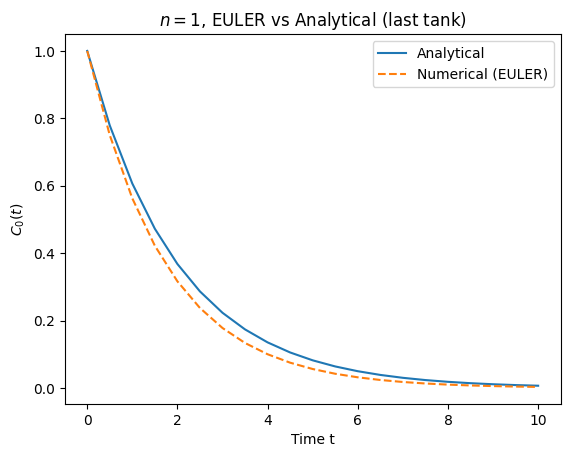

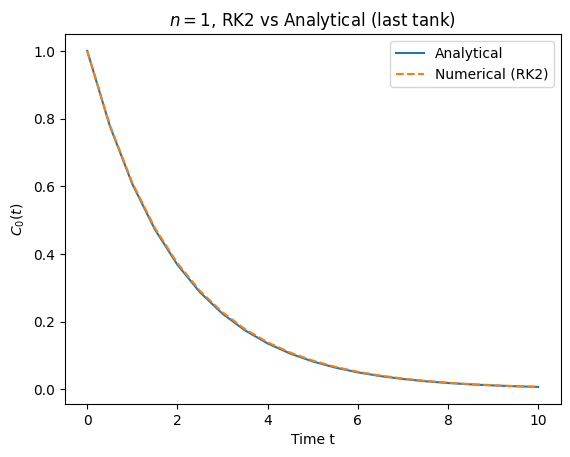

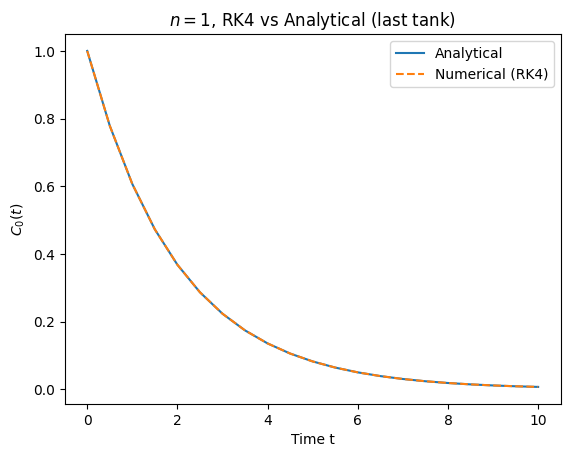

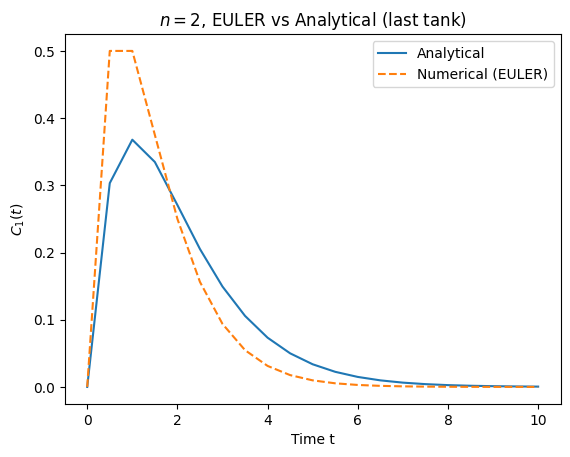

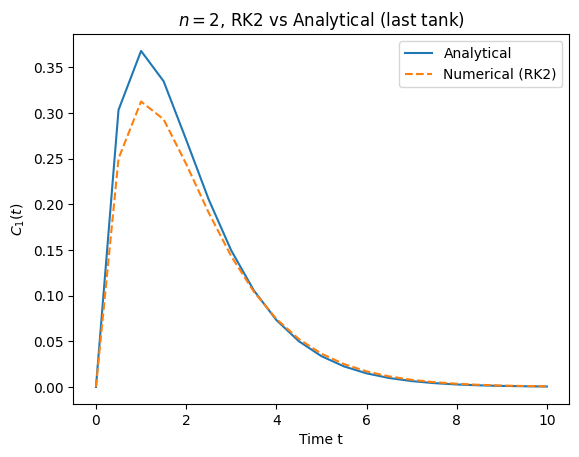

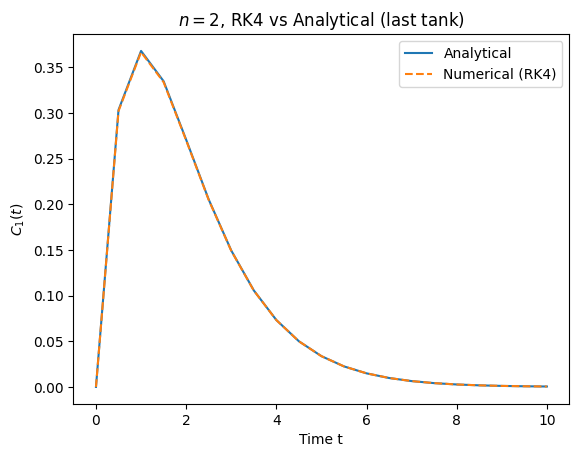

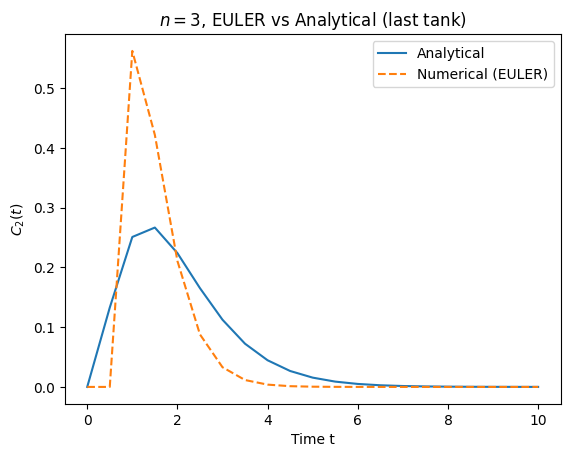

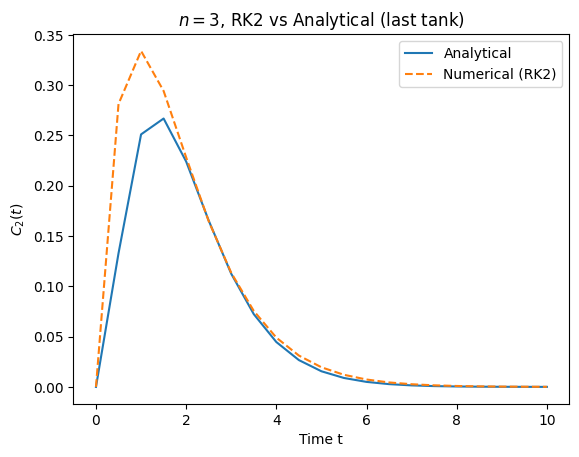

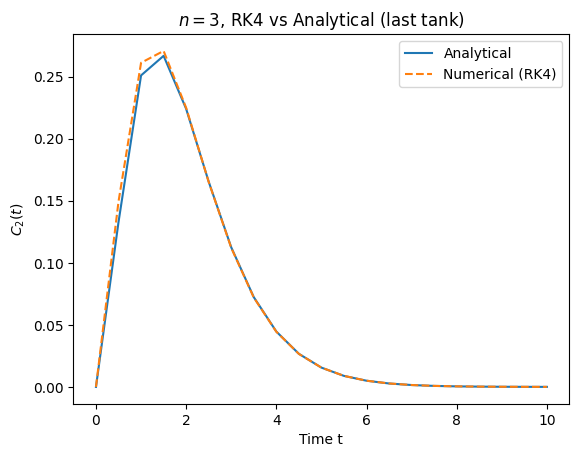

 n method  step_size_h  max_abs_error  L2_error
 1  EULER          0.5       0.051473  0.095718
 1    RK2          0.5       0.004650  0.008951
 1    RK4          0.5       0.000015  0.000028
 2  EULER          0.5       0.196735  0.187414
 2    RK2          0.5       0.055379  0.065702
 2    RK4          0.5       0.001289  0.001585
 3  EULER          0.5       0.311479  0.280680
 3    RK2          0.5       0.148397  0.121980
 3    RK4          0.5       0.016561  0.014043


In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def analytical_last_tank(n, t, tau):

    """
    Analytical concentration in the last tank for an n-CSTR series (n = 1, 2, 3). 

    Parameters
    ----------
    n : int
        Number of tanks (only 1, 2 or 3 are implemented).
    t : Time(s) at which to evaluate the analytical solution.
    tau : Residence time parameter (tau = V_tot / q).

    Returns
    -------
    ndarray or float
        Analytical concentration of the last tank evaluated at t.
    """
    
    if n == 1:
        return np.exp(-t / tau)
    elif n == 2:
        return (2.0 * t / tau) * np.exp(-2.0 * t / tau)
    elif n == 3:
        return (9.0 * (t ** 2) / (2.0 * (tau ** 2))) * np.exp(-3.0 * t / tau)
    else:
        raise ValueError("Analytical expression implemented only for n in {1, 2, 3}.")

# Validation & plotting

tau = 2.0
t0, tf = 0.0, 10.0         # simulate long enough to see decay
h = 0.5                  # step size (can be adjusted to test convergence)
                            #using large h to clearly show solver differences
methods = ["euler", "rk2", "rk4"]


def plot_analytical_vs_numerical(
    tau=tau, 
    t0=t0, 
    tf=tf, 
    h=h, 
    methods=methods
):  

    """
        Plots the analytical vs numerical solution for the last tank in a chain of n tanks,
        and computes error metrics for each method.

        Parameters:
        -----------
        tau : Time constant for the tank system.
        t0 : Initial time of the simulation.
        tf : Final time of the simulation.
        h : Time step size for the numerical solver.
        methods : List of numerical methods to use.

        Returns:
        --------
        records : A list containing error metrics for each method and tank count.
            Each dictionary includes:
                - 'n': number of tanks
                - 'method': name of the numerical method
                - 'step_size_h': time step used
                - 'max_abs_error': maximum absolute error
                - 'L2_error': L2 norm of the error over time
        """



    records = []  # for error table
    for n in [1, 2, 3]:
        # Initial conditions:
        # n=1: C0(0)=1 -> Exponential decay
        # n=2: C0(0)=1, C1(0)=0 -> peak then decay
        # n=3: C0(0)=1, C1(0)=C2(0)=0 -> Lower peak, broader decay
        C_init = np.zeros(n)
        C_init[0] = 1.0

        f = rhs_tanks(n, tau)
        solver = ODESolver(f)

        for method in methods:
            t, C = solver.solve(C_init, (t0, tf), h, method=method)
            num_last = C[:, -1]
            exact_last = analytical_last_tank(n, t, tau)

            # Plot numerical vs analytical for this case
            plt.figure()
            plt.plot(t, exact_last, label="Analytical")
            plt.plot(t, num_last, linestyle="--", label=f"Numerical ({method.upper()})")
            plt.title(f"$n={n}$, {method.upper()} vs Analytical (last tank)")
            plt.xlabel("Time t")
            plt.ylabel(f"$C_{n-1}(t)$")
            plt.legend()
            plt.show()

            # Errors
            max_abs_err = float(np.max(np.abs(num_last - exact_last)))
            l2_err = float(np.sqrt(np.trapezoid((num_last - exact_last) ** 2, t)))
            records.append({
                "n": n,
                "method": method.upper(),
                "step_size_h": h,
                "max_abs_error": max_abs_err,
                "L2_error": l2_err
            })

    return records

records = plot_analytical_vs_numerical()

# Printing error table
df_errors = pd.DataFrame.from_records(records).sort_values(["n", "method"])
print(df_errors.to_string(index=False))

From the plots we can see that with a low step size **h**, the three solvers perform differently for all values of **n**.
The Euler, which is first order, has the largest error of the three and we can see a clear difference between the numerical and analytical solution.
The R2K, being second order, performs better, but still with slight errors.
The R4K, being 4th order, outperforms the two other solvers by far and the numerical solution is almost identical to the analytical solution.

This is also represented in the error table, showing how the R4K outperforms the other solvers by a relative large margin, while the Euler has the largest error.

We can reduce the timestep **h** in order to improve performance and reduce the difference between the numerical and analytical solutions for all solvers.

<span style="color:red"> "It is always good if you can reflect a little bit around why you see what
you see"</span>

**Part 3:** 

Pick n =1, 2, or 3
1. plot the numerical error at t = 1, for the last tank, and for dt values in
the range 0.1, . . . 0.001. (You may try lower values if you have a very fast
solver)
2. does the numerical error scale as expected for Euler, RK2, and RK4?

<span style="color:red">Sjekk gjennom docstringene at de er riktige. Jeg sliter litt med å henge med</span>

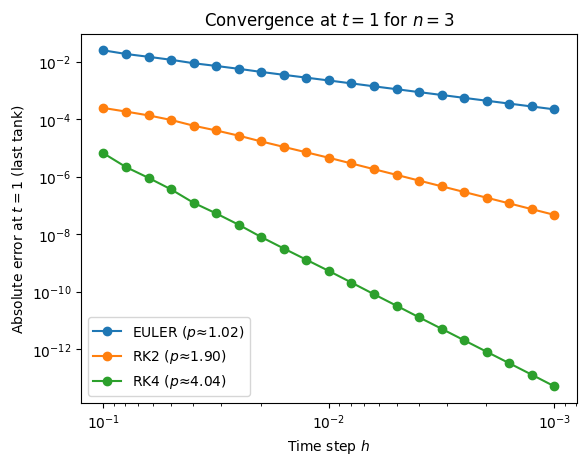

,h,Error EULER,Error RK2,Error RK4
0,0.100000,0.024875,2.457382e-04,6.517022e-06
1,0.079433,0.018560,1.839495e-04,2.159572e-06
2,0.063096,0.014804,1.356097e-04,9.091404e-07
3,0.050119,0.011659,9.401510e-05,3.613335e-07
4,0.039811,0.008842,5.928391e-05,1.230298e-07
5,0.031623,0.007121,4.055454e-05,5.268685e-08
6,0.025119,0.005655,2.670709e-05,2.125489e-08
7,0.019953,0.004407,1.681274e-05,7.937976e-09
8,0.015849,0.003495,1.085072e-05,3.169912e-09
9,0.012589,0.002786,7.029967e-06,1.288515e-09


Observed orders (slope on log-log error vs h):
  EULER: p ≈ 1.017
  RK2: p ≈ 1.901
  RK4: p ≈ 4.037


In [4]:
n_choice = 3
tau = 2.0
t_init = 0.0
t_final = 1.0
dt_vals = np.logspace(-1, -3, 21)  # 0.1 ... 0.001
methods = ["euler", "rk2", "rk4"]



def convergence_errors(
    
    n_choice = n_choice,
    tau = tau,
    t_init = t_init,
    t_final = t_final,
    dt_vals = dt_vals,
    methods = methods
    ):
    """Compute absolute errors at t_final (last tank) for several integrators and timesteps.

    Parameters
    ----------
    n_choice : int
        Number of tanks in the chain.
    tau :Residence time parameter.
    t_init : Initial integration time.
    t_final : Time at which the error is evaluated (last time point).
    dt_vals : array
        Sequence of timestep sizes to test.
    methods : Integrator methods to evaluate (e.g. ["euler","rk2","rk4"]).

    Returns
    -------
    errors -> list of absolute errors at t_final for the last tank.
    """
    errors = {m: [] for m in methods}

    for h in dt_vals:
        C0 = np.zeros(n_choice); C0[0] = 1.0
        f = rhs_tanks(n_choice, tau)
        solver = ODESolver(f)
        for m in methods:
            t, C = solver.solve(C0, (t_init, t_final), h, method=m)
            num = C[-1, -1]
            exact = analytical_last_tank(n_choice, t[-1], tau)
            errors[m].append(abs(num - exact))
    return errors

errors = convergence_errors()

def observed_order(hs, errs, floor=1e-15):
    """
    Estimate the observed convergence order p by fitting a line to the log-log
    relationship between timestep sizes and absolute errors.

    Parameters
    ----------
    hs : Timesteps used in the convergence study.
    errs : array-like
        Absolute errors corresponding to each timestep in `hs`.
    floor :Small positive value used to floor errors before taking the logarithm to
        avoid -inf for zero errors. Default is 1e-15.

    Returns
    -------
    float
        Estimated slope p from a linear fit of log(err) vs log(h). Returns
        np.nan if there are fewer than two valid points for fitting.
    """
    hs = np.array(hs)
    errs = np.maximum(np.array(errs), floor)
    mask = errs > 1e-12
    if np.sum(mask) >= 2:
        x = np.log(hs[mask])
        y = np.log(errs[mask])
        p = np.polyfit(x, y, 1)[0]
        return p
    return np.nan

orders = {m: observed_order(dt_vals, errors[m]) for m in methods}

def plot_errors(
        errors=errors,
        orders=orders,
        methods=methods,
        dt_vals=dt_vals,
        n_choice=n_choice
    ):
    """Plot log-log convergence errors for the given methods.

    Parameters
    ----------
    errors : Mapping method -> list/array of absolute errors.
    orders : Estimated orders for each method.
    methods : Methods to plot.
    dt_vals : array
        Timesteps for the x-axis.
    n_choice : int
        Number of tanks.
    """

    plt.figure()
    for m in methods:
        plt.loglog(dt_vals, errors[m], marker="o", label=f"{m.upper()} ($p≈{orders[m]:.2f})$")
    plt.gca().invert_xaxis()
    plt.xlabel("Time step $h$")
    plt.ylabel("Absolute error at $t=1$ (last tank)")
    plt.title(f"Convergence at $t=1$ for $n={n_choice}$")
    plt.legend()
    plt.show()

plot_errors()

def create_rows(
        errors=errors,
        dt_vals=dt_vals,
        methods=methods
    ):
    """Create rows for error table.

    Parameters
    ----------
    errors : list/array of absolute errors.
    dt_vals : Timesteps for the x-axis.
    methods : Methods used

    Returns
    -------
    list of dict
        Each dict corresponds to a row in the error table.
    """
    rows = []
    for i, h in enumerate(dt_vals):
        row = {"h": h}
        for m in methods:
            row[f"Error {m.upper()}"] = errors[m][i]
        rows.append(row)
    return rows

rows = create_rows()

df = pd.DataFrame(rows)
display(df)

print("Observed orders (slope on log-log error vs h):")
for m in methods:
    print(f"  {m.upper()}: p ≈ {orders[m]:.3f}")

From the convergence plot, we see the errors of the Euler, R2K and R4K solvers on a log-log scale. The Euler slope $\sim 1$, meaning that if we halve **h**, the error is reduced by ~half. The R2K slope is $\sim 2$, meaning that if we halve **h**, the error is reduced by $\sim 4x$. The R4K slope is $\sim 4$, meaning that if we halve **h**, the error is reduced by $\sim 16x$. Each curve shows a smooth line since the error scales with $error(h) ∝ h^p$ (where $p = 1$ for Euler, $2$ for R2K and $4$ for R4K).

The table shows how as the step size **h** gets smaller, the error in each column decreases. We see that Euler has consistently the largest error, whilst the R4K error becomes tiny even for moderate values of **h**. All numerical errors scale as expected.

<span style="color:red"> "It is always good if you can reflect a little bit around why you see whatyou see."   
Kanskje også inkludere hva log-log scale error betyr?</span>

#  Exercise 2: Fit CSTR model to CFD model:Healthy aorta  
**Part 1:**  

Use $M_{inj}$ = 83.333 gram, equation (7) and the data in Healthy_rect_1s.csv to show that q = 5 L/min.

Using the formula we have for q, we can compute an estimate. 
$$
q = \frac{M_{inj}} {\int_0^{\infty} C_{\text{out}}(t) \, dt}
$$

We have been given the $ M_{inj} $. This means we only need the denominator. By using the concentrations in the csv-file, we can find an estimate for the integral. We can only calculate this as we assume that the values of the concentrations are 0 for times $t > t_{last}$ in the csv times.  
The integral can then be estimated by calculating the area of the trapezoid under the graph for each time interval. We can then use np.trapezoid (which calculates the area under the graph using trapezoid method, with inputs $y$ and $x$ as vectors). 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_file(filepath, printing=False):
    """Read CSV with 'Time' and 'Concentration'. Optionally print estimated flow q (L/min).
    Parameters
    ----------
    filepath : str
        Path to the CSV file.
        printing : bool
        
    Returns:
    times: times in the file
    concentrations_out: concentration recordings in the file, corresponding to the times
    """

    data = pd.read_csv(filepath)
    M_inj = 83.333 #grams

    times = np.array(data['Time'])
    concentrations_out = np.array(data['Concentration'])
    
    if printing:
        area_under_curve = np.trapezoid(concentrations_out, times)
        q_estimate = M_inj / area_under_curve * 60 /1000  # Convert to L/min
        print(f"Estimated flow rate q ≈ {round(q_estimate, 3)} L/min")
    return times, concentrations_out


times, concentrations_out = read_file(r'data\healthy_rect_1s.csv', printing=True)

Estimated flow rate q ≈ 5.006 L/min


**Part 2:**  
Make Python functions that reproduces at least three other injection protocol than rect_1s (i.e. minimum four in total) from figure 5.

Using inspiration from both the np.interp function and the if $t < value$. 

In [6]:
def c_inj(t, inj_method="rect", dt = 1):

    """
    Returns the concentration of injected tracer at time t for different injection methods.

    Parameters:
    t : Time at which to evaluate the concentration.
    inj_method : Options are "rect", "ramp", or "biphasic". Default is "rect".
    dt : Duration parameter for the injection profile. Not used for "biphasic".

    Returns:
    Concentration of injected tracer at time t.
    """


    if inj_method == "rect":
        return 1.0 if 0 < t < dt else 0.0

    elif inj_method == "ramp":
        t_vals = [0, dt, dt, dt + 1]
        c = [0, 1, 0, 0]
        return np.interp(t, t_vals, c)
    
    elif inj_method == "biphasic":
        if 0 < t < 1: return 0.75
        elif 2 < t < 3: return 1
        else: return 0.0   
    else:
        raise ValueError("Unknown injection method")
    
# Usage to create a function for c_inj with chosen method and dt
def rect_1s(t):
    return c_inj(t, inj_method="rect", dt=1) # Gives rect 1s function
def rect_2s(t):
    return c_inj(t, inj_method="rect", dt=2) # Gives rect 2s function
def rect_3s(t):
    return c_inj(t, inj_method="rect", dt=3) # Gives rect 3s function
def ramp_1s(t):
    return c_inj(t, inj_method="ramp", dt=1) # Gives ramp 1s function
def ramp_2s(t):
    return c_inj(t, inj_method="ramp", dt=2) # Gives ramp 2s function
def biphasic(t):
    return c_inj(t, inj_method="biphasic") # Gives biphasic function


**Part 3:**
* For the 1s rectangular pulse injection protocol, tune $\tau = \frac{V_{tot}}{q}$ and the number of compartments to match the data for the healthy patient (Healthy_rect_1s.csv).
* Make a figure where you show your "best match". Use scatter points for the data, and solid lines for your simulation.
* "Best match" of $V_{Tot}$ can be done by one of the following methods, there will be an increasing number of points given if you choose the most difficult method
1. (easy) manually adjust V to match data
2. (moderate) use scipy.optimize.curve_fit to find V
3. (hard) In the course we have covered several algorithms that are useful for finding roots and/or minima of functions, e.g., fixed point iteration, Newton’s Raphson’s method, the bisection method, the secant method,
and gradient descent. Implement one of these methods, and use it to find the $\tau$-value that minimizes SSR (see Appendix A).
Hint: Depending on the method(s) you choose, you may have to implement a Python function to calculate the second derivative of $C_2$ with respect to $\tau$.


We use the least square optimization to find the best fitted value for $\tau = V_{tot}/q $, and grid search for number of compartments.  
The solution is given where the derivative of the SSR is zero (We check that it is the global minimum). Therefore we compute a numerical derivative for the SSR at each step, given in appendix A. The formulas we use are:
$$
\frac{dC_{N-1}}{d\tau} = \frac{C_{N-1}(t, \tau + \Delta \tau) - C_{N-1}(t, \tau)}{\Delta \tau}
$$


$$
\frac{dSSR}{d\tau} = 2 \sum_{i=0}^{N-1} r_i \frac{dr_i}{d\tau} = -2 \sum_{i=0}^{N-1} (d_i - C_{N-1}(t_i; \tau)) \frac{dC_{N-1}(t_i; \tau)}{d\tau}
$$  
These formulas are straightforward to implement using NumPy arrays and vectorized operations, which naturally apply the computations element-wise.
We initially considered using Newton's method. However, computing the second derivative of the SSR proved challenging, so we opted for the secant method instead. This method approximates the second derivative and updates the estimate of $\tau$ using the formula:

$$
\tau_{k+1} = \frac{\tau_{k-1} f(\tau _k) - \tau _k f(\tau _{k-1})}{f(\tau _k)-f(\tau _{k-1})}
$$
Where we use the derivative of the SSR as $f$. This formula comes from page 113 in the book. [[Hiorth, 2024]](#hiorth3)  
The method uses the fixed-point iteration, which is a way to rewrite an equation in the form $x=g(x)$. By numericly trying for a starting $x$ one can arrive at an $x$ that gives the same value in the function, i.e $x = g(x)$ (which is what you are trying to solve). What you do is changing $x$ to the value you get from $g(x)$ and trying again until the difference between $x$ and $g(x)$ is close enough. The function $g$ can be very different and have multiple solutions which fit to the answer, however the convergence rate can be very different from different functions. Therefore, one can arrive at the Newton's method which has a very fast convergence fixed point method, proportionally to the error between $x$ and $g(x)$, for each guess. This makes it computationally very good compared to other $g$'s. If we don't have an analytical solution for the derivative of the function (second in our case, since we already want to find 0 for the first derivative), we can use the secant method that uses an approximation of the second derivative in the formula. 

If the difference between the old and the new guess is lower than a low tolerance value, we can assume that this is the minimum for the tau for the specific number of compartments. By some testing we find that the optimal $\tau$-value should be around 2, which is also the value that is given in the first exercise. That is why we start with this value, and use 2.1 for the initial second guess. The first guess is important, as the method only find local minimum values, and not global. It is also stated in the book that the starting point is very important for this method.  
Since we have data for different injection methods, we also aim to find the optimal $\tau$ values for each case to assess their similarity. To do this, we examine the time points and time steps in the CSV files to determine appropriate values $h$, $t_{init}$ and $t_{finish}$.  


In [7]:
def solve_tanks(n=3,
         tau=2.0, 
         method="rk4", 
         h=0.02, 
         t_init=0.0,
         t_final=5.0, 
         c_in_func= lambda t: 0.0,
         C_init=None):
    
    """
    Solve the n-tank mixing ODE system.

    Parameters:
        n (int): Number of tanks.
        tau: Residence time (V_tot/q).
        method: "euler", "rk2", or "rk4".
        h: Time step size.
        t_init: Initial time.
        t_final: Final time.
        c_in_func (function by t): Inlet concentration profile, c_in_func(t).
        C_init (array or None): Initial concentrations (default: zeros, first tank 1).

    Returns:
        t: Time points.
        C: Concentrations in each tank. C[i, j] is concentration in tank j at time t[i].
    """
    
    if C_init is None:
        C_init = np.zeros(n)
    elif C_init.shape[0] != n:
        raise ValueError("C_init length must match number of tanks n.")
    
    f = rhs_tanks(n, tau, c_in=c_in_func)
    solver = ODESolver(f)
    t, C = solver.solve(C_init, (t_init, t_final), h, method=method)
    return t, C


In [8]:
def ssr(modelled, observed):
    """
    Calculate the sum of squared residuals (SSR) between modelled and observed data.

    Parameters:
        modelled: Modelled output values.
        observed: Observed/measured values.

    Returns:
        Sum of squared residuals.
    """

    if len(modelled) != len(observed):

        raise ValueError(f"Modelled and observed arrays must have the same length. Currently the lengths are {len(modelled)} for modelled and {len(observed)} for observed.")
    return np.sum((modelled - observed) ** 2)


def ssr_derivative(n=3, 
                tau=2.0, 
                delta_tau=1e-5,
                method="rk4",
                h=0.02,
                t_init=0.0,
                t_final=5.0,
                c_in_func=rect_1s,
                filepath=r'data\healthy_rect_1s.csv'):
    """
    Compute the sum of squared residuals (SSR) and its numerical derivative with respect to tau.

    Parameters:
        n (int): Number of tanks.
        tau: Residence time parameter.
        delta_tau: Small increment for numerical derivative.
        method: ODE solver method ("euler", "rk2", "rk4").
        h: Time step size for ODE solver.
        t_init: Initial time.
        t_final: Final time.
        c_in_func (function): Concentration profile function of injection.
        filepath: Path to CSV file with observed data.

    Returns:
        ssr_: Sum of squared residuals between model and observed data.
        der_ssr: Numerical derivative of SSR with respect to tau.
    """
    times, concentrations_out = read_file(filepath)
    t, C_model = solve_tanks(n=n,
                             tau=tau,
                             method=method,
                             h=h,
                             t_init=t_init,
                             t_final=t_final,
                             c_in_func=c_in_func)
    t2, C_model_delta = solve_tanks(n=n,
                             tau=tau+delta_tau,
                             method=method,
                             h=h,
                             t_init=t_init,
                             t_final=t_final,
                             c_in_func=c_in_func)
    der_c_out = (C_model_delta[:, -1] - C_model[:, -1]) / delta_tau
    der_ssr = -2*np.sum((concentrations_out-C_model[:,-1])*der_c_out)
    
    ssr_ = ssr(C_model[:, -1], concentrations_out)
    return ssr_, der_ssr

def new_tau(last_tau, current_tau, last_der, current_der):
    """
    Compute the next tau value using the secant method.

    Parameters:
        last_tau: Previous tau value.
        current_tau: Current tau value.
        last_der: Derivative of SSR at last_tau.
        current_der: Derivative of SSR at current_tau.

    Returns:
        Updated guess for tau value. 
    """
    return((last_tau*current_der - current_tau*last_der) / (current_der - last_der))



In [9]:
def secant_optimization(n=3, 
                tau_initial_1=2.0, 
                tau_initial_2=2.1, 
                tol=1e-5,
                der_tol=1e-6,
                max_iter=100,  
                h=0.02,
                t_init=0.0,
                t_final=5.0,
                c_in_func=rect_1s,
                method="rk4",
                delta_tau = 1e-5,
                filepath=r'data\healthy_rect_1s.csv',
                show_err=True):
    """
    Optimize tau for the n-tank mixing model using the secant method to minimize the sum of squared residuals (SSR).

    Parameters:
        n (int): Number of tanks.
        tau_initial_1: First initial guess for tau.
        tau_initial_2: Second initial guess for tau.
        tol: Tolerance for convergence.
        der_tol: Tolerance for derivative magnitude
        max_iter (int): Maximum number of iterations.
        h: Time step size for ODE solver.
        t_init: Initial time for simulation.
        t_final: Final time for simulation.
        c_in_func (function): Concentration profile function of injection.
        filepath: Path to CSV file with observed data.
        show_err (bool): Whether to print iteration details.

    Returns:
        best_tau: Optimized tau value for n.
        best_ssr: SSR at optimized tau.
    """

    tau_last = tau_initial_1
    tau_current = tau_initial_2

    for iteration in range(max_iter):
        ssr_last, der_last = ssr_derivative(n=n, 
                                            tau=tau_last, 
                                            h=h, 
                                            t_init=t_init, 
                                            t_final=t_final, 
                                            c_in_func=c_in_func, 
                                            filepath=filepath, 
                                            method=method,
                                            delta_tau=delta_tau)
        ssr_current, der_current = ssr_derivative(n=n, 
                                                  tau=tau_current, 
                                                  h=h, t_init=t_init, 
                                                  t_final=t_final, 
                                                  c_in_func=c_in_func, 
                                                  filepath=filepath, 
                                                  method=method,
                                                  delta_tau=delta_tau)

        tau_new = new_tau(tau_last, tau_current, der_last, der_current)
        if show_err:
            print(f"it={iteration:02d} tau={tau_current:.3e}  ssr={ssr_current:.3e}  der={der_current:.3e}  h*k={h*n/tau_current:.3e}") 

        #For error finding and control

        # To check if we are at true min 
        if abs(der_current) < der_tol:
            return tau_current, ssr_current

        # To check if we are updating anything
        if abs(tau_new - tau_current) < tol:
            return tau_new, ssr_current

        tau_last = tau_current
        tau_current = tau_new

        if iteration == max_iter - 1:
            raise ValueError(f"No convergence for n={n} within maximum iterations.")


For a easy first check we only use every 10th n. Computationally easier, but gives same overview in plot.

In [10]:
def find_best_n(h=0.02,
                t_init=0.0,
                t_final=5.0,
                c_in_func=rect_1s,
                method= "rk4",
                filepath=r'data\healthy_rect_1s.csv',
                n_values=range(1, 100, 10),
                show_err=True):
    
    results = []
    for n in n_values:
        best_tau, best_ssr = secant_optimization(n=n,
                                                 h=h,
                                                 t_init=t_init,
                                                 t_final=t_final,
                                                 c_in_func=c_in_func,
                                                 method=method,
                                                 filepath=filepath,
                                                 show_err=show_err
                                                 )
        results.append({
            "n": n,
            "best_tau": best_tau,
            "best_ssr": best_ssr
        })
    return pd.DataFrame(results)


We then run through for some of the different data that we have. We are using the RK2 method for the plotting, as the errors that are appearing compared to the RK4 is not very visible in the graphs we would get. However, the computational speed is very different. This is also just for a quick overview.

In [11]:

best10 = [
    find_best_n(method="rk2"),
    find_best_n(t_final=10.0, c_in_func=biphasic, filepath=r'data\healthy_biphasic.csv', method="rk2"),
    find_best_n(t_final=10.0, c_in_func=rect_3s, filepath=r'data\healthy_rect_3s.csv', method="rk2"),
    find_best_n(t_final=10.0, c_in_func=ramp_2s, filepath=r'data\healthy_ramp_2s.csv', method="rk2"),
]


it=00 tau=2.100e+00  ssr=2.568e+01  der=-4.784e+00  h*k=9.524e-03
it=01 tau=2.741e+00  ssr=2.368e+01  der=-1.859e+00  h*k=7.296e-03
it=02 tau=3.149e+00  ssr=2.313e+01  der=-9.488e-01  h*k=6.352e-03
it=03 tau=3.574e+00  ssr=2.286e+01  der=-3.798e-01  h*k=5.596e-03
it=04 tau=3.857e+00  ssr=2.278e+01  der=-1.312e-01  h*k=5.185e-03
it=05 tau=4.007e+00  ssr=2.277e+01  der=-2.934e-02  h*k=4.991e-03
it=06 tau=4.050e+00  ssr=2.277e+01  der=-3.096e-03  h*k=4.938e-03
it=07 tau=4.055e+00  ssr=2.277e+01  der=-8.444e-05  h*k=4.932e-03
it=08 tau=4.055e+00  ssr=2.277e+01  der=-2.522e-07  h*k=4.932e-03
it=00 tau=2.100e+00  ssr=7.843e+00  der=-1.962e+01  h*k=1.048e-01
it=01 tau=2.355e+00  ssr=5.112e+00  der=-2.555e+00  h*k=9.340e-02
it=02 tau=2.394e+00  ssr=5.055e+00  der=-4.512e-01  h*k=9.191e-02
it=03 tau=2.402e+00  ssr=5.053e+00  der=-1.720e-02  h*k=9.159e-02
it=04 tau=2.402e+00  ssr=5.053e+00  der=-1.260e-04  h*k=9.158e-02
it=00 tau=2.100e+00  ssr=5.507e+00  der=-2.919e+01  h*k=2.000e-01
it=01 tau=

The code runs without errors, and one can see that the $\tau$ is converging for all the runs and n's. This is great. Now we plot the different values that we have for an easy overview to see where we should have the n and tau value for a best fit.

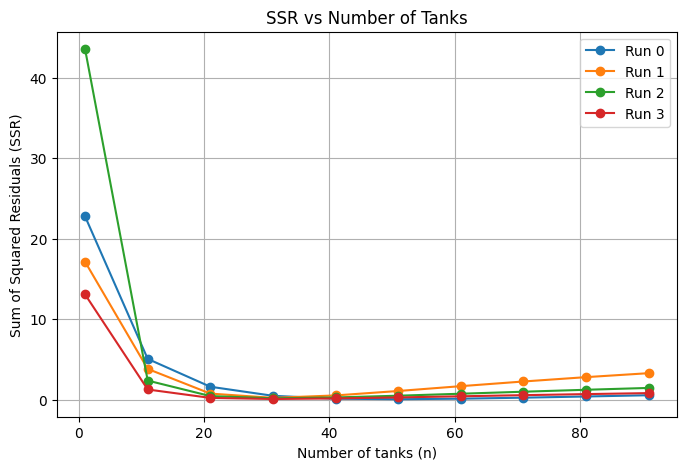

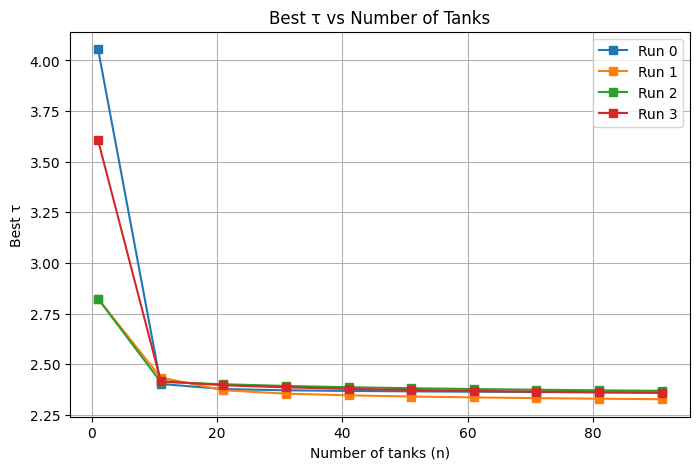

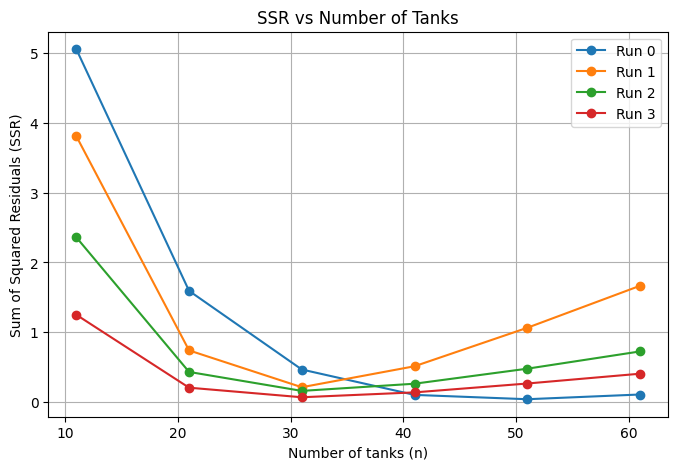

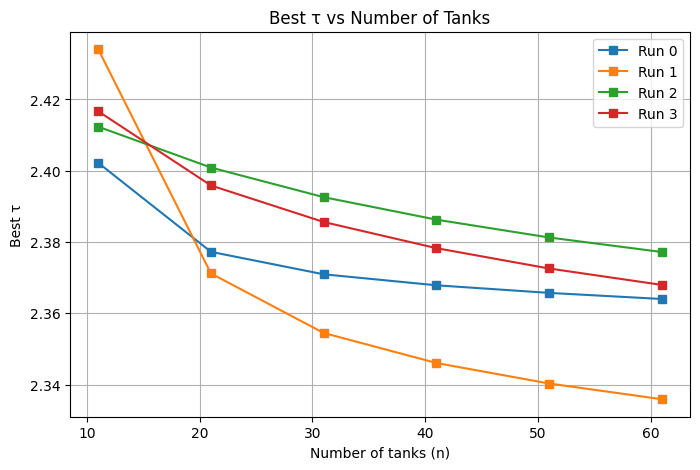

In [12]:
def plot_best(best10):
    plt.figure(figsize=(8, 5))
    for i, df in enumerate(best10):
        plt.plot(df['n'], df['best_ssr'], marker='o', label=f'Run {i}')
    plt.xlabel('Number of tanks (n)')
    plt.ylabel('Sum of Squared Residuals (SSR)')
    plt.title('SSR vs Number of Tanks')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot best τ vs n for each DataFrame
    plt.figure(figsize=(8, 5))
    for i, df in enumerate(best10):
        plt.plot(df['n'], df['best_tau'], marker='s', label=f'Run {i}')
    plt.xlabel('Number of tanks (n)')
    plt.ylabel('Best τ')
    plt.title('Best τ vs Number of Tanks')
    plt.grid(True)
    plt.legend()
    plt.show()
plot_best(best10)
filtered_best10 = [df[(df["n"] > 1) & (df["n"]<70)] for df in best10]
plot_best(filtered_best10)

From the plots we can see that the minimum SSR lies around $n\epsilon[30,40]$ for the lowest SSR's, only for run 1-3. Run 0, which is the rect_1s run and the values we are going to fit the model for, looks like it is minimizes around $n=50$. This corresponds to around $\tau \epsilon [2.35,2.40]$, but is dependent on how many tanks and what injection we use. However, the deviations are small. We see an outlier for run 1, which is the biphasic injection. We can see that the SSR is around 1 for this model at around $n=50$. We will probably see this later when we calculate the SSR against the model fit for rect_1s.    
In the graphs we can see that the SSR is very high for $n=1$, and they are increasing after $n>60$. Therefore, we zoom in to see better. The SSR is probably very high because modelling for one compartment is not physically similar than the aortas that used in the measures.
Next we find the lowest SSR we can get for the healthy_rect_1s.csv data to use for later parts. This by first finding the lowest of the 10-interval points, and then scanning in the 9 nearby values to find the lowest fit for SSR for them all.  
For the next values we want to use RK4 method, because this one is more accurate. Also we are not running through a lot of different, and can therefore allow for more computationally heavy operations.

In [13]:
def best_n_tot(h=0.02,
                t_init=0.0,
                t_final=5.0,
                c_in_func=rect_1s,
                filepath=r'data\healthy_rect_1s.csv',
                n_max=150,
                show_err=False,
                method="rk4"
                ):
    df_results = find_best_n(h=h,
                             t_init=t_init,
                             t_final=t_final,
                             c_in_func=c_in_func,
                             filepath=filepath,
                             n_values=range(1, n_max, 10),
                             show_err=show_err,
                             method=method)
    best_row = df_results.loc[df_results['best_ssr'].idxmin()]
    df_closer = find_best_n(h=h,
                            t_init=t_init,
                            t_final=t_final,
                            c_in_func=c_in_func,
                            filepath=filepath,
                            n_values=range(int(best_row['n'] - 9), int(best_row['n'] + 9)),
                            show_err=show_err,
                            method=method
                            )
    best_row = df_closer.loc[df_closer['best_ssr'].idxmin()]
    return best_row['n'], best_row['best_tau'], best_row['best_ssr']


In [14]:
n_best, tau_best, ssr_best = best_n_tot(n_max=80) # Using rect_1s data as default
print(f"Best number of compartments (n): {n_best}")
print(f"Best tau: {tau_best}")
print(f"Best SSR: {ssr_best}")

Best number of compartments (n): 49.0
Best tau: 2.365364567057784
Best SSR: 0.031563378901011664


As we can see we get a best fit for $n=49$. This is not the greatest general fit, as it is not in the interval $[30,40]$ as we have discussed earlier. However, it is not far away. The best $\tau$ is in the best inteval we found in the graphs. We then plot the values to the true values underneath.

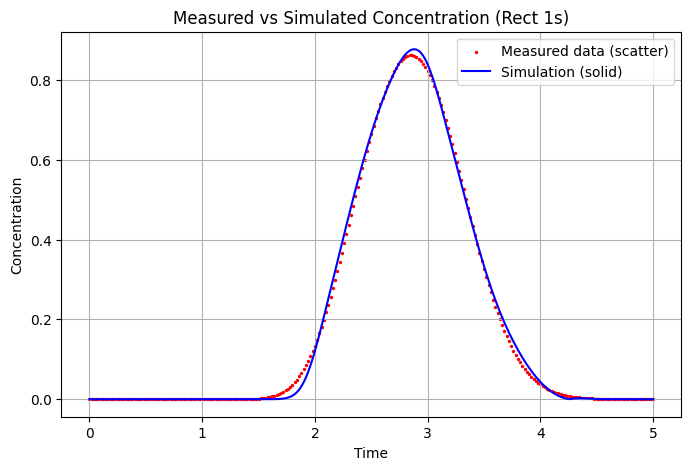

In [15]:
times, concentrations_out = read_file(r'data\healthy_rect_1s.csv')
t, C = solve_tanks(n=int(n_best),
                    tau=tau_best,
                    method="rk4",
                    h=0.02,
                    t_init=0.0,
                    t_final=5.0,
                    c_in_func=rect_1s)

def plot_model_vs_data(times_modelled, modelled, times_observed, observed, inj_func_name = ""):
    if not np.allclose(times_modelled, times_observed, atol=1e-8): #Checking if they match, but also include round off errors for floating points
        raise ValueError("Time arrays for modelled and observed data must match.")
    
    plt.figure(figsize=(8, 5))
    plt.scatter(times_modelled, observed, color='red', label='Measured data (scatter)', s=2)
    plt.plot(times_modelled, modelled, color='blue', label='Simulation (solid)')
    plt.xlabel('Time')
    plt.ylabel('Concentration')
    plt.title(f'Measured vs Simulated Concentration {inj_func_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_model_vs_data(times, concentrations_out, t, C[:, -1], inj_func_name="(Rect 1s)")

The plot shows that the simulated data model is not far off from the measured data that we trained on. The deviations are mostly at the peak a bit under 3 seconds in, or while the concentration outflows are starting to increase at under 2 seconds or right before the concentration outflows ends at aruond 4 seconds.

**Part 4:**  

* Choose at least three other injection protocol than rect_1s from figure 5, use the model you ended up with in part 3 to predict what will happen.
* Illustrate your forecasts with one or more figures where you compare model to data.
* Discuss your findings.

By looking at the previous data we would assume that the models would fit okay with the other data.  
First we create a structured dataframe containing some numpy arrays. This for easy plotting later.

In [17]:
#We are scanning through the CSV files to find the correct value for t_final. We can see that all files have the same h of 0.02, and they all have t_finar of 10.0
scenarios = [
    {"name": "rect_1s",  "t_final": 5.0,  "c_in_func": rect_1s,  "filepath": r"data\healthy_rect_1s.csv"},
    {"name": "rect_2s",  "t_final": 10.0,  "c_in_func": rect_2s,  "filepath": r"data\healthy_rect_2s.csv"},
    {"name": "rect_3s",  "t_final": 10.0, "c_in_func": rect_3s,  "filepath": r"data\healthy_rect_3s.csv"},
    {"name": "biphasic", "t_final": 10.0, "c_in_func": biphasic, "filepath": r"data\healthy_biphasic.csv"},
    {"name": "ramp_1s",  "t_final": 10.0, "c_in_func": ramp_1s,  "filepath": r"data\healthy_ramp_1s.csv"},
    {"name": "ramp_2s",  "t_final": 10.0, "c_in_func": ramp_2s,  "filepath": r"data\healthy_ramp_2s.csv"},
] 



def create_df_runs(scenarios, n_best=n_best, tau_best=tau_best):
    """
    Create a DataFrame containing simulation results and observed data for multiple scenarios.

    Parameters:
    -----------
    scenarios : list of dict
        Each dictionary contains:
            - "name": Name of the scenario.
            - "t_final": Final time for the simulation.
            - "c_in_func": Function defining the inlet concentration profile.
            - "filepath": Path to the CSV file with observed data.
    n_best : Best-fit number of compartments.
    tau_best : Best-fit residence time.

    Returns:
    --------
    df_runs : pandas.DataFrame
        DataFrame with columns:
            - "name": Scenario name.
            - "times_model": Time points from the simulation.
            - "model_out": Simulated outlet concentrations.
            - "times_obs": Time points from the observed data.
            - "obs_out": Observed outlet concentrations.
    """
    rows = []
    for sc in scenarios:

        times_obs, obs = read_file(sc["filepath"])
        
        # Run model for the best parameters
        t_model, C = solve_tanks(
            n=int(n_best),
            tau=tau_best,
            method="rk4",
            h=0.02,
            t_init=0.0,
            t_final=sc["t_final"],
            c_in_func=sc["c_in_func"]
        )
        
        rows.append({
                "name": sc["name"],
                "times_model": t_model,       
                "model_out": C[:, -1],        
                "times_obs": times_obs,       
                "obs_out": obs                
            })
    df_runs = pd.DataFrame(rows)
    return df_runs
df_runs = create_df_runs(scenarios, n_best=n_best, tau_best=tau_best)

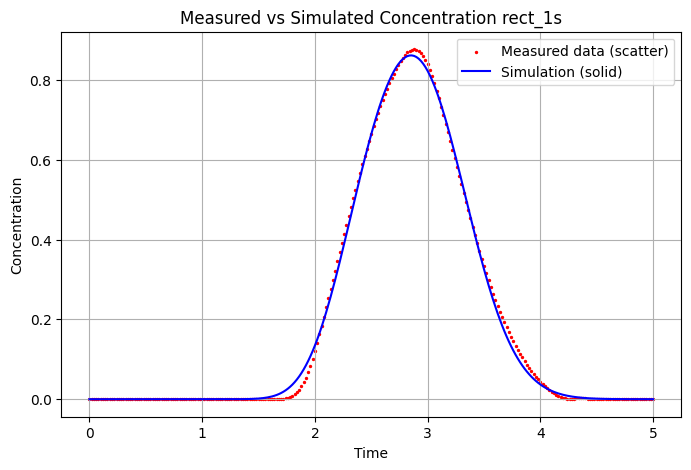

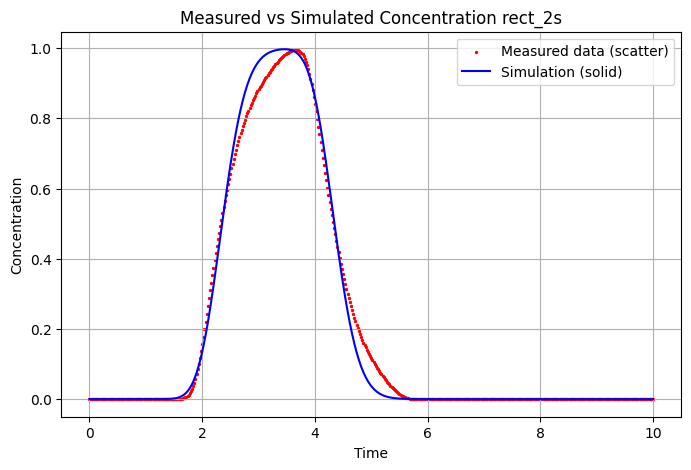

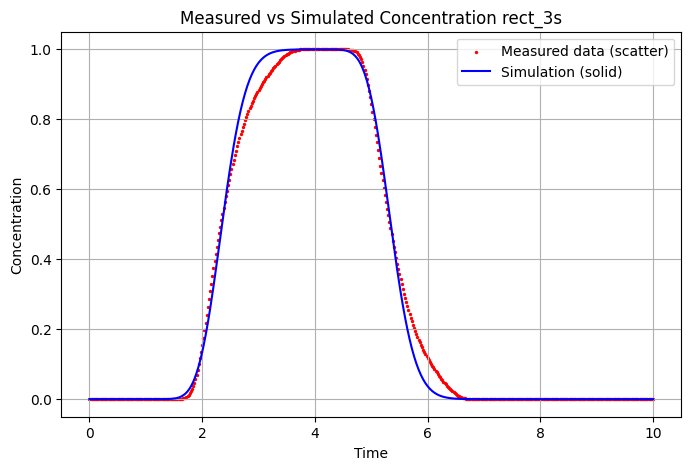

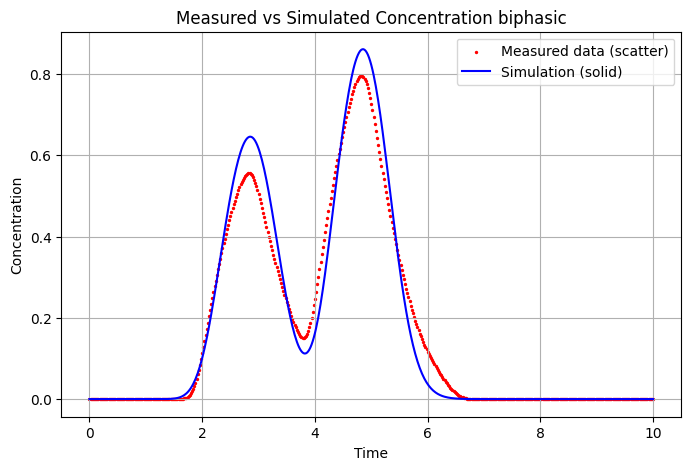

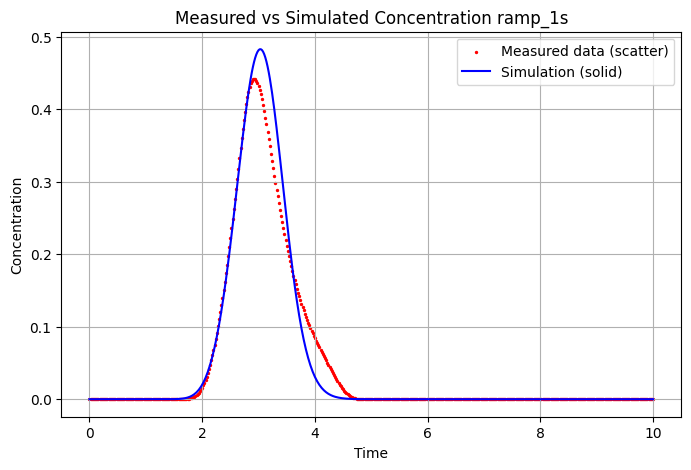

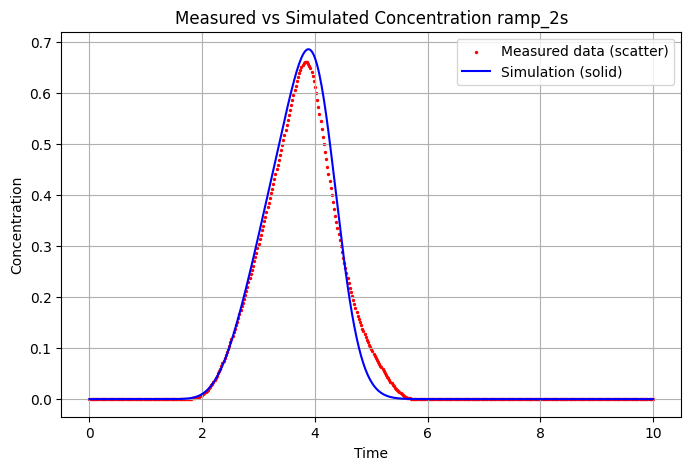

In [18]:
def plot_scenarios(df_runs):
    """
    Iterate through each row in the DataFrame and plot the model vs observed data.
    """
    for row in df_runs.itertuples(index=False): #itertuples for nice and easy retrieving of attributes
        plot_model_vs_data(
            row.times_model,
            row.model_out,
            row.times_obs,
            row.obs_out,
            inj_func_name=f"{row.name}"
        )
plot_scenarios(df_runs)

In [19]:
def calculate_ssr(df_runs):
    for row in df_runs.itertuples(index=False):
        error = ssr(row.model_out, row.obs_out)
        print(f"SSR for {row.name}: {error}")

calculate_ssr(df_runs)

SSR for rect_1s: 0.03156337890093615
SSR for rect_2s: 0.4555294713939334
SSR for rect_3s: 0.45299962813302297
SSR for biphasic: 1.0376392489755504
SSR for ramp_1s: 0.22639822237705423
SSR for ramp_2s: 0.26110418407029523


From the graphs, we can see that the CFD outlet concentration predictions are pretty good and accurate for all injection protocols. The fitted parameters (n and $\tau$) identified using the 1-second rectangular injection yield low SSR, indicating that the n-CSTR model captures important transport dynamics of the healthy aortic arch. As expected, the SSR for the training case (rect_1s) is the lowest, since the model was optimized on that dataset. The low SSR for other injection protocols demonstrates reasonable generalization, showing that the same model can predict the system’s response to new input shapes without having to be re-fitted to a certain degree.

However, if we are to use the models for new, general injection methods, we would definitely encourage using more of the data to fit the number of compartments and $\tau$. If we were to do this now, we would see a smaller SSR, because the model would be trained on the test data (breaking the golden rule of machine learning).

The largest deviations we can see are in the biphasic data. The reason for this is unclear, but it may be due to the more complex shape of the biphasic input, which includes two distinct rising and falling phases. Such complexity could lead to greater deviations in model predictions. Based on the graphs that we made earlier, the best fit for the biphasic function was around $n=30$, and the SSR is steadily increasing after $n=40$. This also comes into play when we are using this model fit. Another thing to mention is that the SSRs from the ramp cases are more accurate (based on the SSR metric) than the rectangular ones. This is also an interesting observation.

Overall, the match between the model and CFD data supports that the n-CSTR framework can serve as an efficient reduced-order representation of the healthy aortic arch. If we were to compare this to aneurysm datasets, we might see that changes in geometry and mixing characteristics result in an increased $\tau$ and broader residence-time distributions.

# Exercise 3: Fit CSTR model to CFD model: Aorta with aneurysm  
**Part 1:**  

* Repeat exercise 2, part 3 for the case of the unhealthy patient with an aneurysm. Note: you have to find new values for $n$ and $V_{Tot}$.
The relevant data is found in the text file Aneurysm_rect_1s.csv.

Just doing the same exact code for the aneurysm_rect_1s case, but changing to aneurysm data.

In [20]:
best10_an = [
    find_best_n(t_final=5.0, c_in_func=rect_1s, filepath=r'data\aneurysm_rect_1s.csv', method="rk2", show_err=False),
    find_best_n(t_final=10.0, c_in_func=biphasic, filepath=r'data\aneurysm_biphasic.csv', method="rk2", show_err=False),
    find_best_n(t_final=10.0, c_in_func=rect_3s, filepath=r'data\aneurysm_rect_3s.csv', method="rk2", show_err=False),
    find_best_n(t_final=10.0, c_in_func=ramp_2s, filepath=r'data\aneurysm_ramp_2s.csv', method="rk2", show_err=False),
]

Again all runs converges to a $\tau$, which is great.

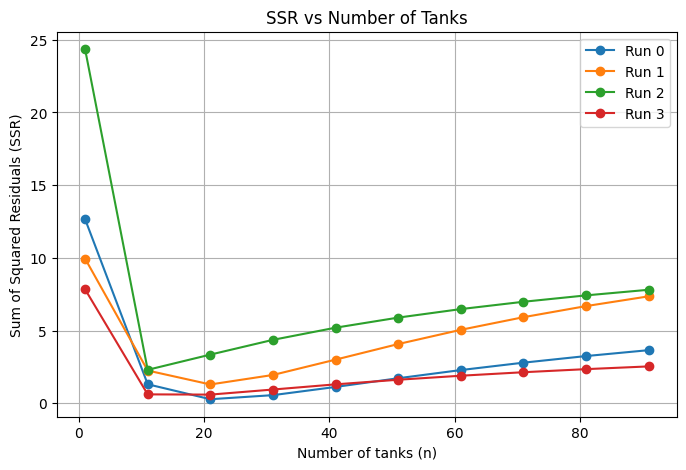

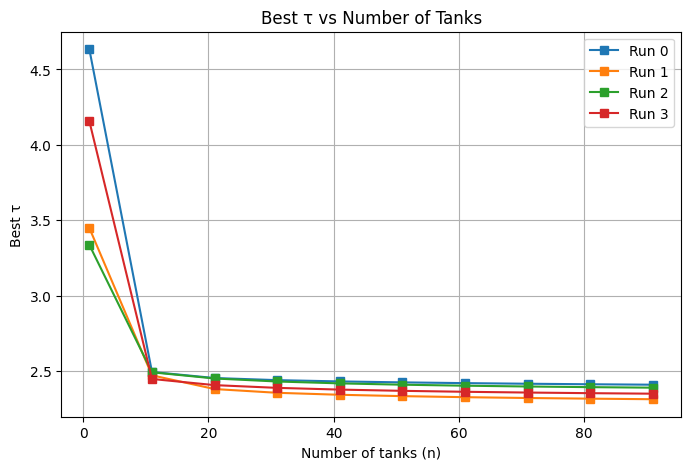

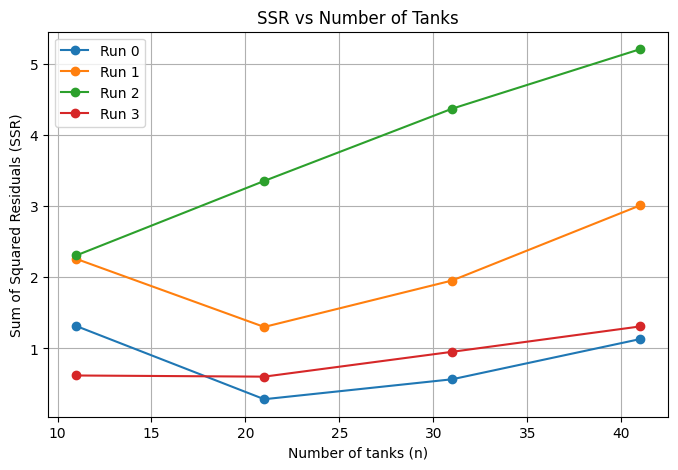

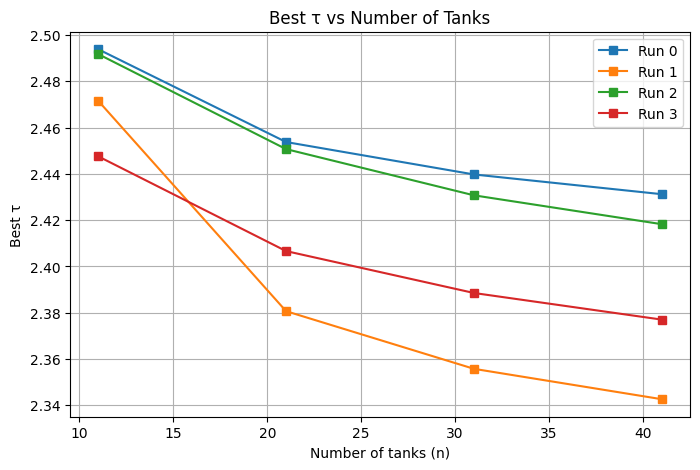

In [21]:
plot_best(best10_an)

filtered_best10_an = [df[(df["n"] > 1) & (df["n"]<50)] for df in best10_an]
plot_best(filtered_best10_an)

From the plots it looks like the functions has lowest points earlier than the healthy case.  
Also plotting the values from $n=5$ to $n=30$ for all the injection methods. Using euler method for a quick run through. We only want an overview.

In [23]:
best_an = [
    find_best_n(t_final=5.0, c_in_func=rect_1s, filepath=r'data\aneurysm_rect_1s.csv', n_values= range(5,30), show_err=False, method="euler"),
    find_best_n(t_final=10.0, c_in_func=rect_2s, filepath=r'data\aneurysm_rect_2s.csv', n_values= range(5,30), show_err=False, method="euler"),
    find_best_n(t_final=10.0, c_in_func=rect_3s, filepath=r'data\aneurysm_rect_3s.csv', n_values= range(5,30), show_err=False, method="euler"),
    find_best_n(t_final=10.0, c_in_func=biphasic, filepath=r'data\aneurysm_biphasic.csv', n_values= range(5,30), show_err=False, method="euler"),
    find_best_n(t_final=10.0, c_in_func=ramp_1s, filepath=r'data\aneurysm_ramp_1s.csv', n_values= range(5,30), show_err=False, method="euler"),
    find_best_n(t_final=10.0, c_in_func=ramp_2s, filepath=r'data\aneurysm_ramp_2s.csv', n_values= range(5,30), show_err=False, method="euler"),
]


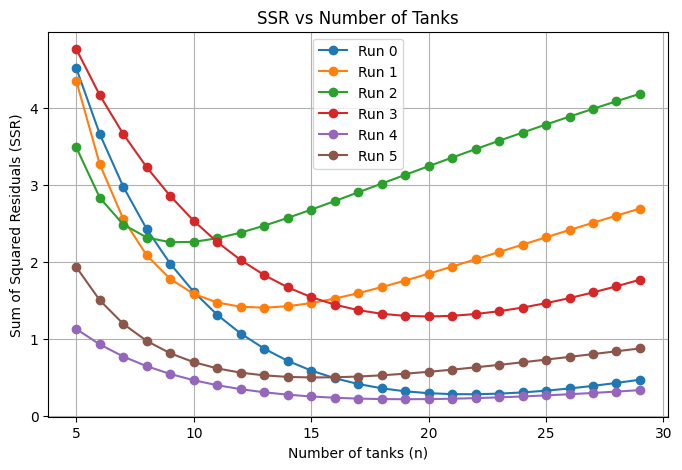

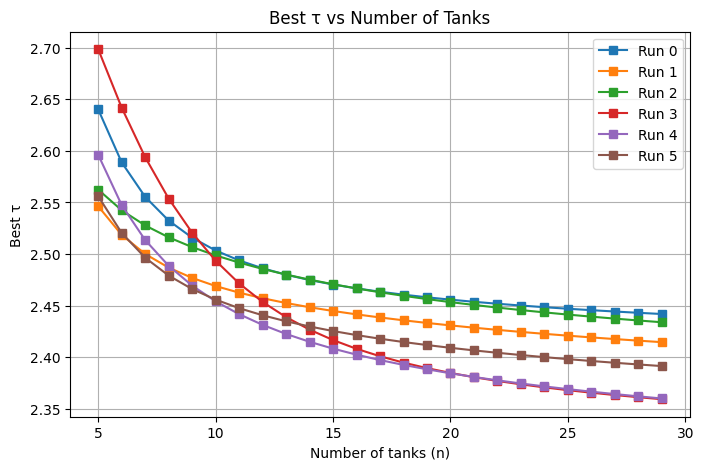

In [103]:
plot_best(best_an)

Here we can see that there is a larger deviation between the optimal solutions of $n$ and $\tau$, in addition to a larger SSR difference. This makes us believe that we are going to see a larger SSR when we try to fit for rect_1s later in the exercise.

In [24]:
n_best_an, tau_best_an, ssr_best_an = best_n_tot(filepath=r'data\aneurysm_rect_1s.csv',n_max=50, show_err=False, method="rk4")
print(f"Best number of compartments (n): {n_best_an}")
print(f"Best tau: {tau_best_an}")
print(f"Best SSR: {ssr_best_an}")

Best number of compartments (n): 21.0
Best tau: 2.4542053215980557
Best SSR: 0.3411804318761896


**Part 2:**  

* Similarly, repeat exercise 2, part 4 for the case with an aneurysm.

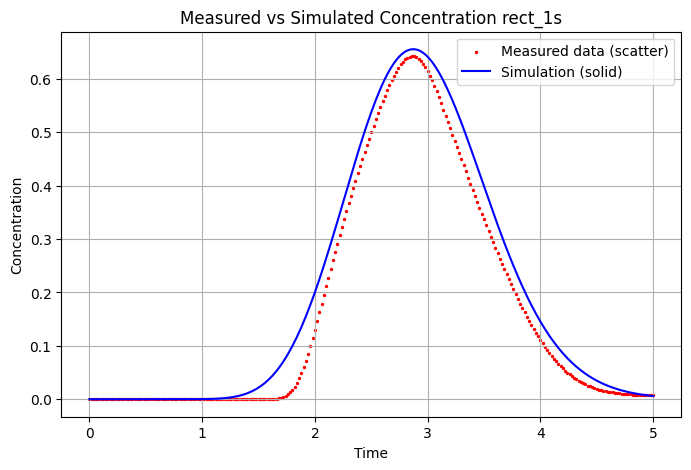

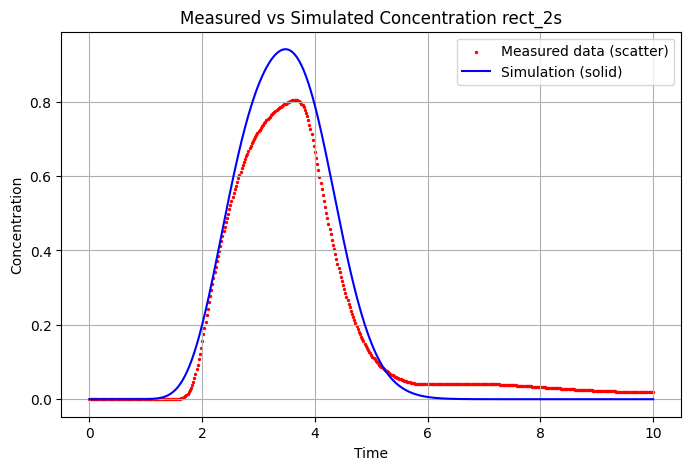

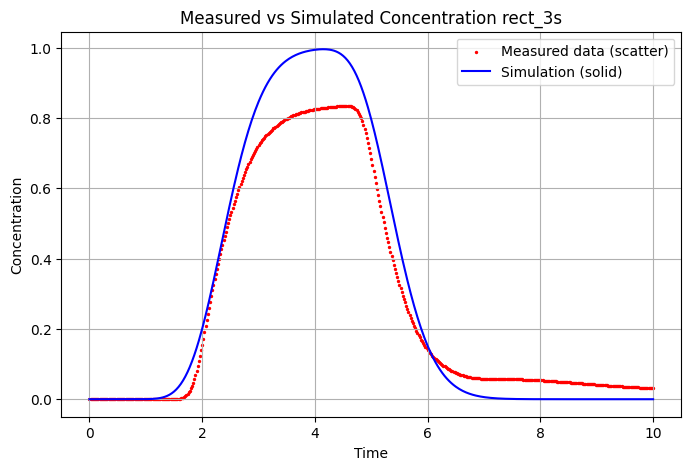

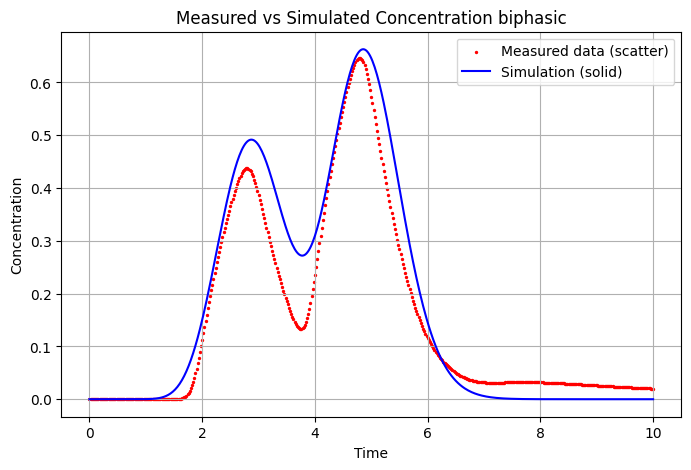

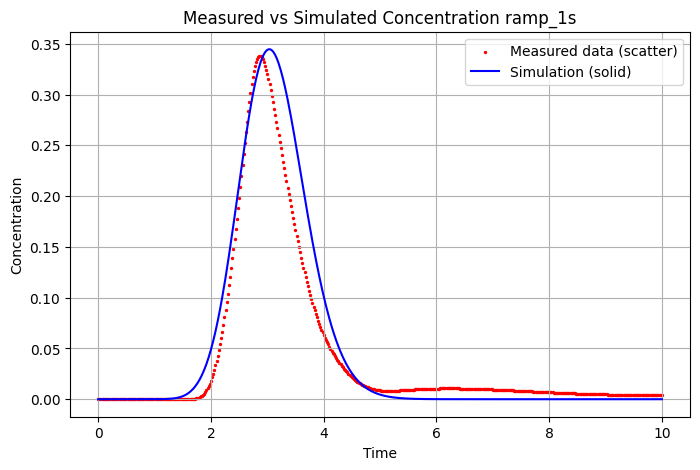

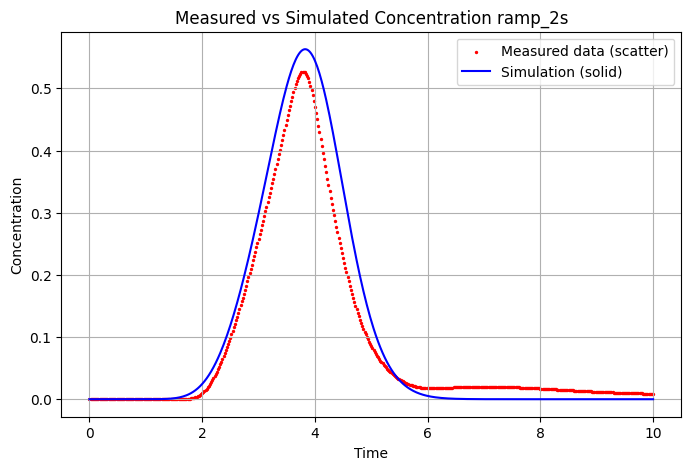

SSR for rect_1s: 0.3411804318753194
SSR for rect_2s: 2.0767326021109973
SSR for rect_3s: 3.45389035149371
SSR for biphasic: 1.6366740781417435
SSR for ramp_1s: 0.3015089715708878
SSR for ramp_2s: 0.6911262451238377


In [26]:
scenarios_an = [
    {"name": "rect_1s",  "t_final": 5.0,  "c_in_func": rect_1s,  "filepath": r"data\aneurysm_rect_1s.csv"},
    {"name": "rect_2s",  "t_final": 10.0,  "c_in_func": rect_2s,  "filepath": r"data\aneurysm_rect_2s.csv"},
    {"name": "rect_3s",  "t_final": 10.0, "c_in_func": rect_3s,  "filepath": r"data\aneurysm_rect_3s.csv"},
    {"name": "biphasic", "t_final": 10.0, "c_in_func": biphasic, "filepath": r"data\aneurysm_biphasic.csv"},
    {"name": "ramp_1s",  "t_final": 10.0, "c_in_func": ramp_1s,  "filepath": r"data\aneurysm_ramp_1s.csv"},
    {"name": "ramp_2s",  "t_final": 10.0, "c_in_func": ramp_2s,  "filepath": r"data\aneurysm_ramp_2s.csv"},
] 

df_runs_an = create_df_runs(scenarios_an, n_best=n_best_an, tau_best=tau_best_an)
plot_scenarios(df_runs_an)
calculate_ssr(df_runs_an)

From the data, we can see that the model doesn’t fit the aneurysm cases as well as it does for the healthy ones. One reason could be that the aneurysm creates a larger volume near the end of the aorta, which the model doesn’t account for. In our setup, we assume that all compartments have the same volume and that the flow is smooth throughout the aorta. These assumptions might not hold in the aneurysm case, which could explain the worse fit.  
We also notice that the ramp_1s injection gives a lower SSR than the rect_1s case, even though the model was trained on rect_1s. This might seem strange, but it makes sense when we think about how the model works. The CSTR model assumes smooth flow between compartments. A rectangular injection has a sudden jump up and down, which is harder for the model to handle. It might also cause more turbulence or unpredictable flow, which the model can’t capture. That could be why the SSR is higher for rect_2s and rect_3s, while the ramp cases have lower SSRs.

**Part 3:**  
* Compare the number of compartments you ended up with in the two cases (healthy vs. aneurysm). Was it very different, why / why not?

We see that the number of compartments required to fit the outlet tracer concentration was quite a lot lower for the aneurysm case (n = 21) compared to what we found for the healthy aorta (n = 49). This suggests that the aneurysm introduces flow dispersion and recirculation, increasing the residence-time distribution (as we predicted in Ex 2 part 4). In other words, the flow becomes less plug-like and more mixed.

The residence time $\tau$ was slightly higher in the aneurysm case which is consistent with a larger effective volume and slower washout of tracer. The higher SSR in the aneurysm fit also indicates that the simple CSTR-in-series model cannot perfectly represent the complex, 3D structures typical of aneurysmal flow.

Overall, both the decrease in n and the increase in $\tau$ are clear indicators of altered blood flow caused by the aneurysm. These parameters could potentially serve as measurable physiological indicators, For example, a drop in n (more dispersion) or an increase in $\tau$ (longer residence) could signal abnormal flow associated with aneurysmal expansion.

**Part 4:**  
Discuss strengths and weaknesses of the CSTR approach. What have you learned from this exercise?

**Strengths:**

* Simplicity and computational efficiency.
The n-CSTR removes the complex 3D flow problem with a simple system of ODEs. It can be solved in milliseconds using our ODE solvers (Euler, R2K and R4K), in contrast to the CFD simulations which can take far longer. With this in mind, this model is ideal for parameter studies, optimization or diagnostics application where we need to repeat a lot of evaluations.

* Physical interpretation
The number of tanks ($n$) and residence time ($\tau$) have clear physical meaning. $n$ describes the degree of mixing whilst $\tau$ describes the mean residence time of tracer in the system. This allows us to do a direct physiological interpretation, like we did when comparing healthy aortic arch vs anaurism, by looking at the changes in effective volume.

* Generalization
Once calibrated, the model can predict system behavior for new injection protocols (as we discussed in Ex 2 part 4). This shows that the parameters capture essential system properties rather than being tied to one specific input.

**Weaknesses:**

* Loss of spatial resolution
The CSTR approach assumes that each tank is perfectly mixed, meaning that spatial information within each compartment is lost. This means that it cannot capture detailed flow structures such as recirculation zones, secondary flow pattern or velocity gradients within the aortic arch.

* Empirical parameter estimation
The parameters $n$ and $\tau$ are not directly measurable, but need to be obtained from data sets. This can include issues such as sensitivity to the choice of datasets, and noise in the data.


* Limited accuracy for complex geometries
As we saw for the aneurysm comparison, flow separation and vortex formation cause deviations from the ideal "well-mixed-in-series" assumption. The model thus is therefore a worse fit for such cases (higher SSR) and may not be as good to represent key transport occurences like backflow or local stagnation.


**What we learned from this exercise:**

Effective modeling can replace full CFD for key metrics. Even though the n-CSTR model is simple, it can capture the transport behavior of a complex system quite well. This shows that  reduced-order models can be powerful for analysis and diagnostics as long as they are properly calibrated.

Parameter trends reflect physical changes. Comparing healthy and aneurysm cases we saw how changes in $n$ and $\tau$ values reflect real physiological differences (an increased dispersion $n$ and longer residence time $\tau$ due to aneurysm dilation.

Understanding trade-off between accuracy and simplicity. As with all modeling, we need to consider what we are aiming to obtain (quick analysis or detailed simulation). The CSTR model is easy to use, but cannot fully reproduce the 3D flow complexity. CFD gives more detail, but at higher computational cost. 

# Exercise 4 (OPTIONAL): Extend model

**Part 1:**

Add equation (8) to your $n$ compartment model, at a specific position towards the outlet.
1. Are you able to match the Aneurysm data better now?
2. What is the optimal values for $D$, and $V_A$?

How we aim to achieve this:
1. Add state variable $C_A$ and modify the RHS to couple the chosen tank $k$ to a pocket
2. Simulate the extened ODE model
3. Fit $D$ and $V_A$ using best-fit $n$ and $\tau$
4. Recompute SSR for aneurysm_rect_1s
5. Compare SSR before/after and reflect if this matches the aneurysm data better
6. Extract optimal $D$ and $V_A$

Given equation (8):
$$V_A \frac{dC_A}{dt} = D(C_i - C_A)$$ 
where 
* $C_i(t)$ is the concentration of one of the main CSTR tanks along the aortic arch
* $C_A(t)$ is the concentration in the aneurysm cavity/side pocket
* $V_A$ is the effective volue of that aneurysm pocket
* $D$ is an exchange coefficient with units of volume/time [g/ml]

We can rewrite equation (8) as:
$$\frac{dC_A}{dt} = \frac{D}{V_A} (C_i - C_A)$$
We can say that:
* If $C_i > C_A$, the tracer leaks into the aneurysm pocket
* If $C_i < C_A$, the tracer leaks back from the pocket
* The larger $V_A$, the slower the $C_A$ changes for a given exchange
* The larger $D$, the faster the pocket communicates with the main flow

This gives us what we are looking for in an aneurysm; trapped volume with slow exchange.

Then, we can update our ODE system and our n-CSTR model by attaching the aneurysm pocket $k_{leak}$ to tank $i$.
Equation 8 aldready gives us the ODE for $C_A$, but we need to add the equal and opposite to include the situations where loses tracer by exchange with the aneurysm pocket.
$$\frac{dC_A}{dt} = \frac{D}{V_A} (C_{k_{leak}} - C_A)$$
Where our tank $k_{leak}$ is a modification of the original ODE with added term of opposite sign:
$$\frac{dC_k}{dt} = \frac{n}{\tau} (C_{k-1} - C_k) - D(C_k - C_A)$$
Here, the fitting constant $D$ is an effective rate constant telling us how strongly the tank is being leaked into the eneurysm volume. We keep the model simple by re-using the fitting constant $D$ in both directions.
This gives us a 1-compartment slow-storage effect that feeds back into the main path. 

In [27]:
# Building RHS for n-tank CSTR-in-series with one aneurysm pocket
def rhs_tanks_with_aneurysm(n, tau, c_in, k_leak, D, V_A):
    """
    Parameters:
        n: number of main tanks in series
        tau: residence time (V_tot / q)
        c_in: inlet concentration function of time, C_in(t)
        k_leak: index of the tank (0..n-1) that links to the aneurysm pocket
        D: exchange coefficient between tank k_leak and aneurysm pocket
        V_A: aneurysm pocket volume parameter in eq (8)

    Returns:
        f(C_full, t): function that computes dC_full/dt
                      where C_full[0:n] are main tanks, C_full[n] is C_A
    """
    k_flow = n / tau  # same as previously

    def f(C_full, t):
        C_main = C_full[0:n]   
        C_A    = C_full[n]

        dCdt_main = np.zeros_like(C_main)

        # tank 0: driven by inlet
        dCdt_main[0] = k_flow * (c_in(t) - C_main[0])

        # tanks 1..n-1: normal series flow
        for j in range(1, n):
            dCdt_main[j] = k_flow * (C_main[j-1] - C_main[j])

        # modify the leak tank: subtract exchange with aneurysm pocket
        dCdt_main[k_leak] += - D * (C_main[k_leak] - C_A)

        # aneurysm pocket ODE from eq (8):
        # V_A dC_A/dt = D (C_i - C_A)
        # rewritten to dC_A/dt = (D / V_A) (C_i - C_A)
        dCdt_A = (D / V_A) * (C_main[k_leak] - C_A)

        # stack back together
        return np.concatenate([dCdt_main, np.array([dCdt_A])])

    return f


In [28]:
# Defining new solver to simulate the new extended model

def solve_tanks_with_aneurysm(n,
                              tau,
                              D,
                              V_A,
                              k_leak,
                              method="rk4",
                              h=0.02,
                              t_init=0.0,
                              t_final=5.0,
                              c_in_func=lambda t: 0.0):
    """
    Solve n-tank model + aneurysm pocket.
    Returns:
        t : time array
        C_full : concentrations, shape (len(t), n+1)
                 columns 0..n-1 = tanks, column n = aneurysm pocket
    """
    f = rhs_tanks_with_aneurysm(
        n=n,
        tau=tau,
        c_in=c_in_func,
        k_leak=k_leak,
        D=D,
        V_A=V_A,
    )

    solver = ODESolver(f)  # reusing previous class

    # initial condition: all zero tracer
    C0_full = np.zeros(n + 1)

    t, C_full = solver.solve(C0_full, (t_init, t_final), h, method=method)
    return t, C_full

    C_out_model = C_full[:, n-1]  # Comparison to CDF - NOT the aneurysm state


In [29]:
# Simulating the extended model

def ssr_aneurysm_extended(n,
                          tau,
                          D,
                          V_A,
                          k_leak,
                          c_in_func,
                          h,
                          t_init,
                          t_final,
                          filepath):

    times_obs, obs_out = read_file(filepath)

    t_model, C_full = solve_tanks_with_aneurysm(
        n=n,
        tau=tau,
        D=D,
        V_A=V_A,
        k_leak=k_leak,
        method="rk4",
        h=h,
        t_init=t_init,
        t_final=t_final,
        c_in_func=c_in_func
    )

    model_out = C_full[:, n-1]  # outlet is last main tank

    # align times
    if len(times_obs) != len(t_model) or not np.allclose(times_obs, t_model):
        model_out_interp = np.interp(times_obs, t_model, model_out)
        return ssr(model_out_interp, obs_out)
    else:
        return ssr(model_out, obs_out)



In [30]:
# Brute-forcing scanning for fitted parameters D and V_A
n_fixed   = int(n_best_an)
tau_fixed = tau_best_an

best_ssr_ext = np.inf
best_D = None
best_VA = None
best_k = None

for k_leak in [n_fixed-1, n_fixed-2, n_fixed-3]:   # try attaching pocket near outlet
    for D_try in np.linspace(0.0, 2.0, 41):        
        for VA_try in np.linspace(0.1, 5, 50):   
            val = ssr_aneurysm_extended(
                n=n_fixed,
                tau=tau_fixed,
                D=D_try,
                V_A=VA_try,
                k_leak=k_leak,
                c_in_func=rect_1s,
                h=0.02,
                t_init=0.0,
                t_final=5.0,
                filepath=r"data\aneurysm_rect_1s.csv"
            )

            if val < best_ssr_ext:
                best_ssr_ext = val
                best_D = D_try
                best_VA = VA_try
                best_k = k_leak

print("Extended model best SSR:", best_ssr_ext)
print("Original aneurysm SSR  :", ssr_best_an)
print("Improvement factor     :", ssr_best_an / best_ssr_ext)

print("Best D   :", best_D)
print("Best V_A :", best_VA)
print("Best k_leak (tank index):", best_k)


Extended model best SSR: 0.18426796694168854
Original aneurysm SSR  : 0.3411804318761896
Improvement factor     : 1.8515449947095575
Best D   : 0.8
Best V_A : 5.0
Best k_leak (tank index): 20


We see that the improvement factor between the orignial SSR and exended model SSR is ~1.85, meaning that the extended model has a significant error reduction improvement.
The plain n-CSTR model is not good enough to explain the aneurysm tracer washout, but by adding a single slow-exchange reservoir (aneurysm pocket) to the flow path the model is able to explain the data much better, meaning that the aneurysm flow is not just better mixed, but acts like a distinct volume that fills and then bleeds tracer back over time. Our model is now able to create recirculation zones and low-velocity pockets.

As mentioned earlier, the exchange coefficient $D$ controls how strongly tank $i$ exchanges tracer with the aneurysm pocket. With best $D$ of 0.8, we see that the tracer is is not completely isolated and that the tracer gets in and out on a relevant time scale.
If our $D$ value were extremely small, this would mean that the aneurysm pocket almost traps tracer and barely releases it.
If our $D$ were extremely large, this would mean the pocket would mix instantaneously and stop acting like a reservoir.
In our case, exchange exists but it is not instantaneous.

$V_A$ in the pocket ODE acts like an effective recirculating volume. Bigger $V_A$ means that it takes longer for that pocket to equilibrate with the main flow because any given exchange dilutes more tracer mass.
With our $V_A$ value of 5, which is at the upper end of our scan range (0.1 - 5)* .This means that the aneurysm behaves like a large side volume, and has a significant capacity to hold tracer and delay its release.
If we were to expand our $V_A$ range, we could potentially get a better SSR and reinforce the analysis that the aneurysm is not just another CSTR in the chain, but its own added-on storage chamber.

From earlier we have best fit $n=20$ compartments, and now for the the best fit $k_{leak}=21$ compartments, meaning that the aneurysm pocket is best modeled as being attached at the very last compartment in the transport chain, just before the outlet. This means that we are able to locate the aneurysm downstream end of the path of the 1D model.

*This was proven with experiments outside of this project delivery; Higher $V_A$ range would indeed improve SSR, but at a computational higher cost. With $V_A$ range of 0.1 - 20, the SSR improvement factor was ~2.2 but took much longer to compute.

# Summary

Through this project we have demonstrated that the n-CSTR model can reproduce the outlet tracer concentration predicted by the CFD simulations with high accuracy. The models simplicity and computational efficiency make it an attractive reduced-order alternative for analyzing and diagnosing vascular flow conditions.

For the healthy aorta, we found a relatively high number of compartments ($n=49$) and a moderate residence time ($\tau=2.36$), representing near plug-flow (no mixing in direction of flow) behavior with limited dispersion. In contrast to this, we saw that the aneurysm case required fewer compartments ($n=21$) and a slightly longer residence time ($\tau=2.45$), which is consistent with increased mixing and longer tracer retention due to the expanded geometry.

By extending the model with an aneurysm side compartment, we were able to improve the fit (SSR reduced by a factor of ~1.85) and got physically interpretable variables: Exchange rate $D = 0.8$ and aneurysm volume $V_A = 5.0$. These values indicate a large, slow exchanging reservoir near the outlet of the aortic arch.

Overall, the project shows how reduced-order models can serve as efficient diagnostics tools capturing essential transport characteristics with low computational cost while giving meaningul analysis and interpretation.

# Bibliography  

<div id="hiorth3"></div> **A. Hiorth**.  *Computational Engineering and Modeling*, https://github.com/ahiorth/CompEngineering, 2021.